# Tucker Model

#### Pseudo code
* create individuals
* assign status
* for (at=1:num.timesteps) { <br>
    infection <br>
    calculate number of acts <br>
    determine who has an act with whom (ie construct "edgelist") <br>
    limit edgelist to discordant pairs <br>
    determine infections <br>
    do bookkeeping for infections <br>
    recovery <br>
    identify infecteds <br>
    determine recoveries <br>
    do bookkeeping for recoveries <br>
}

In [107]:
# Libraries/packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import optimize

In [108]:
#fix random seed for reproducibility

np.random.seed(seed=42)

### Camp Structure

In [109]:
Nb = 8100          # Number of people in isoboxes.
mub = 10           # Isoboxes mean occupancy (people).
hb = Nb / mub      # Number of isoboxes. 
iba = 0.5          # Proportion of area covered by isoboxes.

Nt = 10600         # Number of people in tents.
mut = 4            # Tents occupancy of (people).
ht = 10600 / mut   # Number of tents.

fblocks = np.array([1,1])   # initial sectoring. Divide camp into (nxn) grid, each with its own food line.
N = Nb + Nt                 # Total population.


### Emperical Age and Sex Distribution

In [110]:
path_to_file = 'age_and_sex.csv'            # Observed data.
age_and_sex = pd.read_csv(path_to_file)     # Data frame. V1 = age, V2 is sex (1 = male?, 0  = female?).
#type(age_and_sex)

# Remove "Unamed column" and preview.
age_and_sex = age_and_sex.loc[:, ~age_and_sex.columns.str.contains('^Unnamed')]
age_and_sex.head() 

,V1,V2
0,2.1,1
1,25.6,0
2,23.6,0
3,49.6,1
4,28.6,0


In [111]:
print(age_and_sex.describe())     # Summary stats.
age_and_sex = age_and_sex.values  # dataframe to 2D array.
#type(age_and_sex)
#age_and_sex[:5,]

                 V1            V2
count  12883.000000  12883.000000
mean      25.615687      0.541877
std       16.570576      0.498263
min        0.100000      0.000000
25%       14.700000      0.000000
50%       24.600000      1.000000
75%       35.100000      1.000000
max       89.700000      1.000000


### Transmission parameters

In [112]:
# Infection
twh = 0.5   # Probability of infecting each person in your household per day.
aip = 0.1   # Probability of infecting each person you meet per meeting (Fang et al.)
tr = 1      # Initial transmission reduction (relative to assumed per contact transmission rate, outside household only).

### Other parameters

In [113]:
siprob = 0        # Probability of spotting symptoms, per person per day.
clearday = 7      # Days in quarantine after no virus shedding (i.e., recovery).
pac = 0.179       # Permanently asymptomatic cases (Mizumoto et al 2020 Eurosurveillance).
ss = 0.20         # Realtive strength of interaction between different ethnicities.

### Initial movement parameters
Note that the initial assumption is that
everyone uses the larger radius some proportion of the time, which is
__NOT__ the same as assuming that some people always use the larger radius,
Nonetheless, I am setting the proportion equal to the number of males age 10-50 in the population.

In [114]:
lr1 = 0.02       # Smaller movement radius. Range around their household during lockdown or females and individuals age < 10.
lr2 = 0.1        # Larger movement radius. ie. Pople who violate lockdown enforcement or males over age 10.
lrtol = 0.02     # Scale interactions - two people with completely overlapping rages with this radius interact once per day

### Create population matrix (pop)
Columns:
0. Home number
1. Disease state: 0 = susceptible, 1 = exposed, 2 = presymptomatic, 3 = symptomatic, 4 = mild, 5 = severe, 6 = recovered. Similar states in quarentine are the same plus seven. In other words, this is a categorical variable with values between 0 and 13 inclusive.
2. Days to symptoms for this person
3. Days passed in current state
4. Whether this person will be asymptomatic
5. Age
6. Male: = 1 if male.
7. Chronic: = 1 if chronic disease?
8. Wanderer (Uses the larger radius).

pop is $N \times 9$

#### Columns 0-1 (House number and disease state)

- Randomly assign each person to a household (rN).
- Draw a sample from uniform distribution between 1-810 (hb). Meaning we chose a random isobox.
- Then repeat that 8100 (Nb) times. AKA assign each person to an isobox.
- Do the same for the tent group.
- Indices (ui) of the unique array that reconstruct the input array (rN).
- The number of inidces should equal total population (N).
- Note: Household column is not the huse itself but the index of that house hold.
- Start each person as susceptible (col 1 = 0).
- Randomly assign one person to be exposed to the virus (pop[someindex,1]=1).

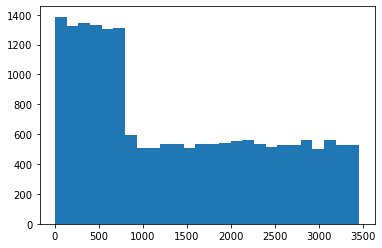

In [115]:
rN = np.concatenate((np.ceil(hb*np.random.uniform(0,1,Nb)), hb+np.ceil(ht*np.random.uniform(0,1,Nt)))) 
plt.hist(rN,bins='auto')
plt.show()

U,ui = np.unique(rN, return_inverse=True)  # ui - indices from the unique sorted array that would reconstruct rN
assert U[ui].all() == rN.all()

pop_2 = np.column_stack((np.sort(ui), np.zeros((ui.shape)))) # Size N x 2 (18700 x 2).
assert pop_2.shape==(18700, 2)

pop_2[np.random.randint(0,N),1] = 1

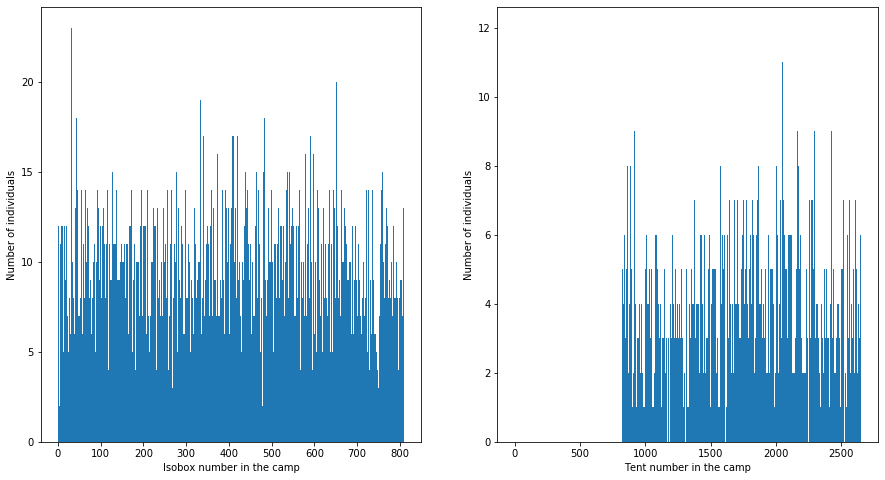

In [116]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.set_ylabel('Number of individuals')
ax1.set_xlabel('Isobox number in the camp')
ax1.hist(rN[:Nb+1], bins=np.arange(1,hb+1))
ax2 = fig.add_subplot(122)
ax2.set_ylabel('Number of individuals')
ax2.set_xlabel('Tent number in the camp')
ax2.hist(rN[Nb+1:], bins=np.arange(1,ht+1))
plt.show()

#### Columns 2-4 (symptoms)
- Col 2: Days to first symptoms (if they develop symptoms) for each person, following (Backer et al. 2020 Eurosurveillance)
- Col 3: Days passed in current state, 0 for now.
- Col 4: Whether this person will be asymptomatic.

In [117]:
k = (2.3/6.4)**(-1.086)
L = 6.4 / (math.gamma(1 + 1/k))
pop_5 = np.column_stack( (pop_2, k*np.random.weibull(L,(N,1)), np.zeros((N,1)), np.random.uniform(0,1,N)<pac*(N/(N-300))) )
assert pop_5.shape==(18700, 5)

#### Columns 5-6 (Age and sex)
- Get N random samples from the distribution in the observed data with repetition.
- Assign age and sex following the observed distribution in the camp.

I believe I treated the age and sex distributions as separate whereas I think I should treat
the age and sex for a give individual together (if that makes sense?).
i.e. I got the sex and age samples on their own where as the original Matlab code gets them
from the age-sex pairs: age_and_sex(randsample(size(age_and_sex,1),N,true),:)

However, the distributions seem equal in the original program and here.

Billy: I have editted here by drawing samples from rows 

In [118]:
age_and_sex_N=age_and_sex[np.random.randint(age_and_sex.shape[0], size=N), :]

In [119]:
# Is this approach correct?
pop_7 = np.column_stack((pop_5,
                       age_and_sex_N[:,0],
                       age_and_sex_N[:,1]))
assert pop_7.shape==(18700, 7)

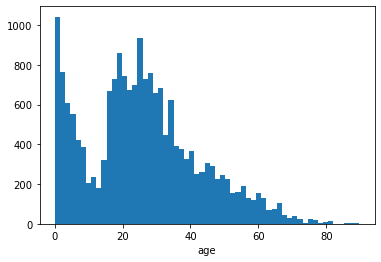

In [120]:
plt.hist(pop_7[:,5],bins='auto')
plt.xlabel('age')
plt.show()

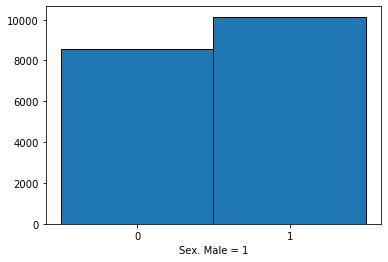

In [121]:
plt.hist(pop_7[:,6], bins=[-0.5,0.5,1.5], ec="k")
plt.xticks((0,1))
plt.xlabel('Sex. Male = 1')
plt.show()

#### Column 7-8 (Chronic States and wanderers)
- Matching the relationship between age and chronic states in the data.
- Males over the age of ten are wanderers.

There is a bug somewhere in the lambda function that makes the minimum (xopt) is too small compared to the original program (~1.62) which causes (rchron) to be 1 for all individuals ... which then makes the asymptomatic column all equal to zero.

Would it be sensible to put an upper limit on the age when defining wanderers? ie. 10 < age < 60

Billy: I am guessing the original equation is trying to find the xopt that makes myfunction-N equals to 0 according to the plot below because otherwise fmin will take the value xopt way to the left. But yeah I am confused in how this equation is produced here - we are aiming to assing 300 people or so with chronic conditions right?

Gonzalo: Fixed. We get ~300 counts.

In [122]:
myfunction = lambda x: np.absolute(300-np.sum((1+np.exp(-(x-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2))**(-1))))-N
xopt = optimize.fsolve(myfunction, x0=[2])
print(xopt)

[1.52000207]


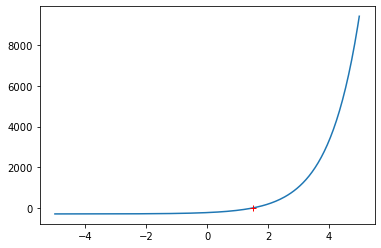

In [123]:
x_s= np.linspace(-5, 5, 201)
y=[myfunction(x) for x in x_s]
plt.plot(x_s, y,xopt,myfunction(xopt),'r+')
plt.show()

In [124]:
#rchron=myfunction(xopt)
rchron = (1+np.exp(-(xopt-11.69+.2191*pop_7[:,5]-0.001461*pop_7[:,5]**2)))**(-1)
chroncases = (np.random.uniform(np.min(rchron),1,N) < rchron) 

pop_8 = np.column_stack( (pop_7, chroncases))
assert pop_8.shape==(18700, 8)

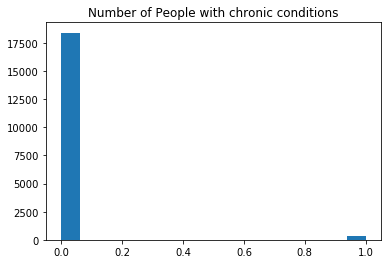

In [125]:
chroncases[np.where(chroncases == 1)]
plt.hist(chroncases.astype(int),bins='auto')
plt.title('Number of People with chronic conditions')
plt.show()

294


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


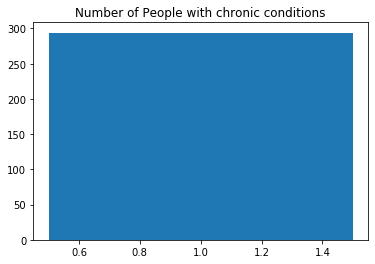

In [126]:
print(np.sum(chroncases))
plt.hist(chroncases[np.where(chroncases == 1)],bins='auto')
plt.title("Number of People with chronic conditions")
plt.show()

In [127]:
# Ensure that people with chronic conditions are not asymptomatic, and correct number of asymptomatics above.
# In other words, if chronic conditions = 1 then not asymptomatic.
pop_8[ pop_8[:,7] == 1,4 ] = 0 
pop_9 = np.column_stack( (pop_8, np.logical_and([pop_8[:,6] == 1], [10 <= pop_8[:,5]]).transpose() ) ) # Wanderers
assert pop_9.shape==(18700, 9)

### Create households
- pph is people per household
- hhloc are the x and y coordinates of each household
- Assign household locations, with isoboxes occupying a square in the center

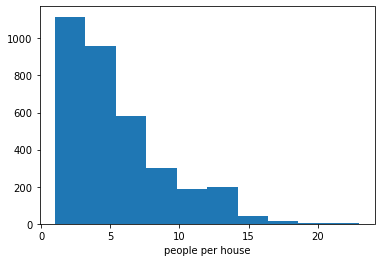

3414
3460.0
3413.0


In [128]:
pph = np.bincount(ui)
maxhh = pph.size

plt.hist(pph)
plt.xlabel('people per house')
plt.show()

print(maxhh)  # This number is different than total number of house holds
print(ht+hb)
print(pop_9[-1,0]) # Index of last house, so house number is index +1

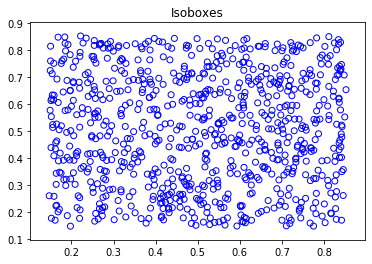

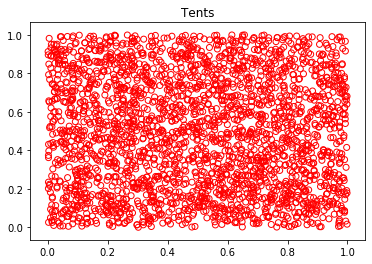

In [129]:
# Assign x and y coordinates to isoboxes (there are hb total isoboxes). 
hhloc1 = 0.5*(1-np.sqrt(iba)) + np.sqrt(iba)*np.random.uniform(0,1,(int(hb),2))
plt.scatter(hhloc1[:,0], hhloc1[:,1],facecolors='none', edgecolors='b')
plt.title('Isoboxes')
plt.show()

# Repeat for tents.
#hhloc2 = np.random.uniform(0,1,(int(ht),2))
hhloc2 = np.random.uniform(0,1,(int(pop_9[N-1,0]-pop_9[Nb-1,0]),2)) # Note: Nb-1 and N-1 to account for zero-indexing.
plt.scatter(hhloc2[:,0], hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

assert (hhloc1.shape[0]+hhloc2.shape[0] == maxhh)

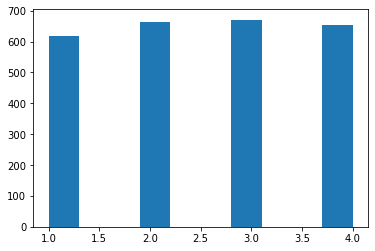

In [130]:
# Randomly move tents to the edges of the camp. Assign weights to them.
hhloc2w = np.ceil(4*np.random.uniform(0,1,(int(pop_9[N-1,0]-pop_9[Nb-1,0]),1)))
plt.hist(hhloc2w)
plt.show()

assert len(hhloc2w) == hhloc2.shape[0]

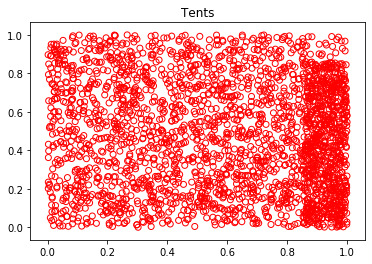

In [131]:
# This block moves some tents to the right edge.

shift = 0.5*(1-np.sqrt(iba))
# print(shift)
# print(1-shift)

# temp = np.copy(hhloc2) # Make deep copy for testing
# temp[np.where(hhloc2w==1),0] = 1+shift*(hhloc2[np.where(hhloc2w == 1),0]-1)
# temp[np.where(hhloc2w==1),1] = (1-shift)*hhloc2[np.where(hhloc2w == 1),1]
#plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==1),0] = 1+shift*(hhloc2[np.where(hhloc2w == 1),0]-1)
hhloc2[np.where(hhloc2w==1),1] = (1-shift)*hhloc2[np.where(hhloc2w == 1),1]

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

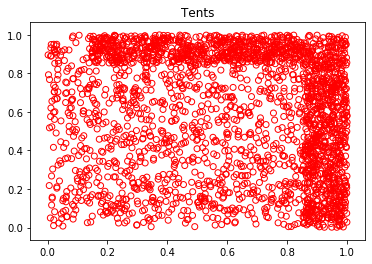

In [132]:
# This block moves some tents to the upper edge.

# temp[np.where(hhloc2w==2),0] = hhloc2[np.where(hhloc2w == 2),0]*(1-shift)+shift
# temp[np.where(hhloc2w==2),1] = 1+shift*(hhloc2[np.where(hhloc2w == 2),1]-1)
# plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==2),0] = hhloc2[np.where(hhloc2w == 2),0]*(1-shift)+shift
hhloc2[np.where(hhloc2w==2),1] = 1+shift*(hhloc2[np.where(hhloc2w == 2),1]-1)

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

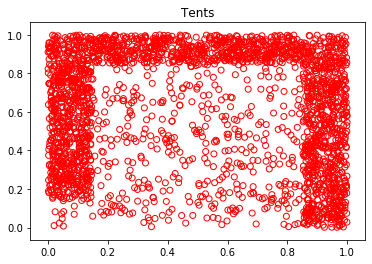

In [133]:
# This block moves some tents to the left edge.

# temp[np.where(hhloc2w==3),0] = shift*hhloc2[np.where(hhloc2w == 3),0]
# temp[np.where(hhloc2w==3),1] = hhloc2[np.where(hhloc2w == 3),1]*(1-shift)+shift
#plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==3),0] = shift*hhloc2[np.where(hhloc2w == 3),0]
hhloc2[np.where(hhloc2w==3),1] = hhloc2[np.where(hhloc2w == 3),1]*(1-shift)+shift

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

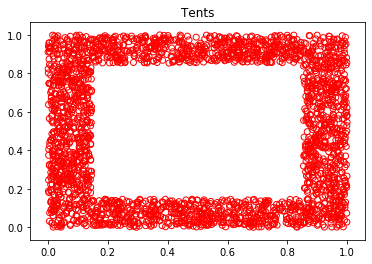

In [134]:
# This block moves some tents to the bottom edge.

# temp[np.where(hhloc2w==4),0] = (1-shift)*hhloc2[np.where(hhloc2w == 4),0]
# temp[np.where(hhloc2w==4),1] = shift*hhloc2[np.where(hhloc2w == 4),1]
# plt.scatter(temp[:,0],temp[:,1],facecolors='none', edgecolors='r')

hhloc2[np.where(hhloc2w==4),0] = (1-shift)*hhloc2[np.where(hhloc2w == 4),0]
hhloc2[np.where(hhloc2w==4),1] = shift*hhloc2[np.where(hhloc2w == 4),1]

plt.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r')
plt.title('Tents')
plt.show()

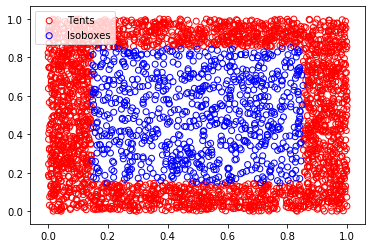

In [135]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(hhloc2[:,0],hhloc2[:,1],facecolors='none', edgecolors='r', label='Tents')
ax1.scatter(hhloc1[:,0],hhloc1[:,1],facecolors='none', edgecolors='b', label='Isoboxes')
plt.legend(loc='upper left');
plt.show()

hhloc = np.vstack((hhloc1,hhloc2)) 
assert hhloc.shape[0] == maxhh

### POSITION TOILETS
- Toilets position make an evely spaced $nx \times ny$ grid throughout the camp.
- Create where 1 indicates that households share the same toilet.

In [136]:
def assignBlock(hhlocc,maxhh,blocks):
    """
    Out
    num: Assign a block to a household (ie. toilet block or food line)
    shared: A Matrix of shared blocks at the household level.
    """
    grid1 = np.sum(np.outer(hhloc[:,0],np.ones((1,blocks[0])))>np.outer(np.ones((maxhh,1)),np.arange(1,blocks[0]+1)/blocks[0]),1)
    grid2 = np.sum(np.outer(hhloc[:,1],np.ones((1,blocks[1])))>np.outer(np.ones((maxhh,1)),np.arange(1,blocks[1]+1)/blocks[1]),1)
    num = grid2*blocks[0]+grid1+1
    TEMP = np.outer(num,np.ones((1,len(num))))
    shared = (TEMP.T == TEMP) - np.eye(maxhh)
    return [num,shared]

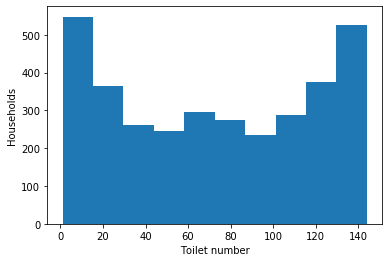

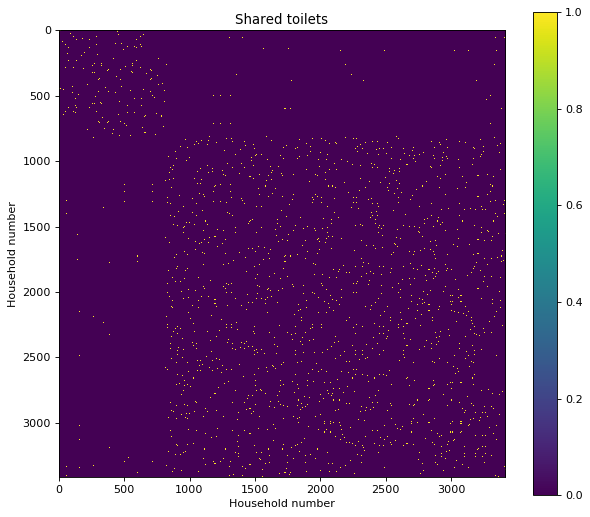

In [137]:
nx = 12
ny = 12
tblocks = np.array([nx,ny])       # Grid dimensions.
tgroups = tblocks[0]*tblocks[1]   # Number of blocks in the grid.
tu = N/tgroups                    # ~ people / toilet

# Assign a toilet number to a household nad what.
[tnum,tshared] = assignBlock(hhloc,maxhh,tblocks)
assert np.max(tnum) == np.prod(tblocks)
assert tshared.shape == (maxhh,maxhh)

plt.hist(tnum)
plt.ylabel('Households')
plt.xlabel('Toilet number')
plt.show()

fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(tshared)
plt.title('Shared toilets')
plt.xlabel('Household number')
plt.ylabel('Household number')
plt.colorbar()
plt.show()

### Create ethnic groups
- Households are assigned to ethnicities.
- Ethnic groups are spatially clustered and randomly positioned
- The distribution matches the distribution of people in the Moria data.
- Only ethnicities with > 50 people in the observed data included.

How do we account for ethnicities with < 50 peolpe?

In [138]:
# Number of people in each group.
Afghan = 7919 ; Cameroon = 149 ; Congo = 706 ;Iran = 107 ;Iraq = 83 ; Somalia = 442 ; Syria = 729
g = np.array([Afghan,Cameroon,Congo,Iran,Iraq,Somalia,Syria])  

# Im not sure what this number represents exactly. I believe its related to population but it does not equal sum(g).
totEthnic = 15327  
totEthnic == np.sum(g)

g = np.round(maxhh*g/totEthnic)              # Number of households per group.
g = np.random.choice(g,len(g),replace=False) # Randomize group order.

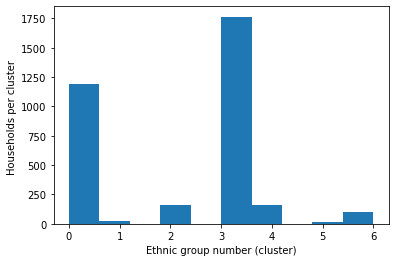

In [139]:
# Randomly chose a household (location), and assign an ethnicity to the n nearest households.

hhunass = np.column_stack((np.arange(0,maxhh), hhloc))   # Unassigned households. Firsto column is the index of the hh.
hheth = np.zeros((maxhh,1))                              # Ethnic households

for i in range(len(g)):
    gcen = hhunass[np.random.randint(hhunass.shape[0]),1:] # Chose an unassigned household as the group (cluster) centre.
    dfromc = np.sum((hhunass[:,1:]-np.tile(gcen,(hhunass.shape[0],1)))**2,1) # Squared distance to cluster centre.
    cloind = np.argsort(dfromc)                            # Get the indices of the closest households (cloind).
    hheth[hhunass[cloind[0:int(g[i])],0].astype(int)] = i  # Assign i-th ethnic group to those households.
    hhunass = np.delete(hhunass,cloind[0:int(g[i])],0)     # Remove those hoseholds (remove the i-th cluster/ethnic group)
    
plt.hist(hheth)
plt.ylabel('Households per cluster ')
plt.xlabel('Ethnic group number (cluster)')
plt.show()

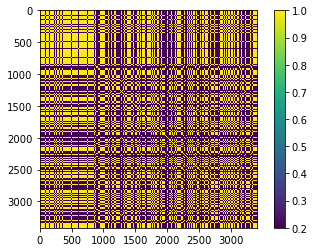

In [140]:
# Scale local interactions strength for ethnicities

# plt.imshow(np.tile(hheth,(1,len(hheth))))
# plt.colorbar()
# plt.show()

# plt.imshow( np.tile(hheth,(1,len(hheth))).T )
# plt.colorbar()
# plt.show()

ethmatch = ( np.tile(hheth,(1,len(hheth))) ==  np.tile(hheth,(1,len(hheth))).T )
ethcor = ethmatch+ss*(1-ethmatch)

plt.imshow( ethcor )
plt.colorbar()
plt.show()

### Create interaction rates

In [141]:
def make_obs_180420(fblocks,lr1,lr2,N,hhloc,maxhh,lrtol,ethcor):
    """
    fshared: matrix that indictes whether two households use the same food distribution center.
    lis: matrix that holds local interacton stregth between members of different households.
    tl: probability of transmission per local interaction
    tt: probability of transmission per regional interaction (i.e., 3x daily toilet visits,
    from either person before or person after)
    tg: probability of transmission per global interaction (i.e., 3x daily food lines, from either person before or 
    person after, but only 1/4 of people go to the food line each time to  collect for household).
    """
    # fgroups = np.prod([fblocks]) # Number of feeding groups.
    # fu = N/fgroups # Individuals per feeding group.
    
    # 1) Assign households to feeding blocks. Make matrix of shared feeding blocks at the household level.
    [fnum,fshared] = assignBlock(hhloc,maxhh,fblocks) 
    
    # 2) Compute interaction rates among households.
    # Distance matrix between households.
    hhdm = np.sqrt((np.tile(hhloc[:,0],(hhloc.shape[0],1)).T - np.tile(hhloc[:,0],(hhloc.shape[0],1)))**2 + 
                   (np.tile(hhloc[:,1],(hhloc.shape[0],1)).T - np.tile(hhloc[:,1],(hhloc.shape[0],1)))**2)  
    
    # 3) Compute the lens of shared area between households, scaled for the density
    # with which individuals occupy that lens (which decreases in proportion to
    # the area of the lens. Here, poeij is the density overlap between
    # individuals using radii i and j, respectively (but poeij=poeji).    
    poe11 = np.nan_to_num(np.real(2*lr1**2*np.arccos(hhdm/(2*lr1)) -
                    np.multiply(0.5*hhdm,np.sqrt(np.multiply((2*lr1-hhdm),(2*lr1+hhdm))))) / (math.pi**2*lr1**4))
    poe22 = np.nan_to_num(np.real(2*lr2**2*np.arccos(hhdm/(2*lr2)) -
                    np.multiply(0.5*hhdm,np.sqrt(np.multiply((2*lr2-hhdm),(2*lr2+hhdm))))) / (math.pi**2*lr2**4))
    poe12 = np.real(lr1**2*np.arccos( (hhdm**2+lr1**2-lr2**2) / 2*hhdm*lr1 ) +
                    lr2**2*np.arccos( (hhdm**2+lr2**2-lr1**2) / 2*hhdm*lr2 ) -
                    np.multiply(np.multiply(-hhdm+lr1+lr2,hhdm+lr1-lr2),np.multiply(hhdm-lr1+lr2,hhdm+lr1+lr2)))    
    poe12 = poe12 / (math.pi**2*lr2**2*lr1**2)
    np.fill_diagonal(poe12,0)
    
    # Scale to standard by which 2 people occupying the same circle with radius
    # lrtol have one interaction per day. Store in a 3-D array.    
    lis = np.multiply(math.pi*lrtol**2*np.dstack((poe11,poe12,poe22)),np.dstack((ethcor,ethcor,ethcor)))
    
    # % %SET LOCAL REGIONAL AND GLOBAL TRANSMISSION PROBABILITIES. This computes
    # % %the probability of transmission per encounter times the number of
    # % %encounters between individuals per day
    # % tl=aip*tr;                  %local
    # % tt=aip*tr*(2*3)/tu;         %toilet - assume possible transmission to person before or after
    # %                             %in line, 3 times per day
    # % tg=aip*tr*(2*3*(1/4))/fu;   %global - assume possible transmission to person before or after
    # %                             %in line, 3 times per day, but 1/4 of people go    
    
    return fshared, lis

C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in arccos
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in arccos
C:\Users\Gonzalo\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


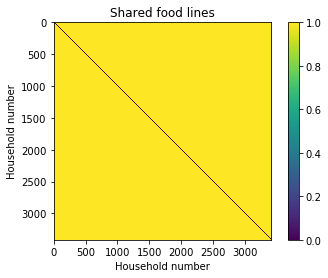

In [142]:
fshared, lis = make_obs_180420(fblocks,lr1,lr2,N,hhloc,maxhh,lrtol,ethcor)
plt.imshow(fshared)
plt.title('Shared food lines')
plt.xlabel('Household number')
plt.ylabel('Household number')
plt.colorbar()
plt.show()

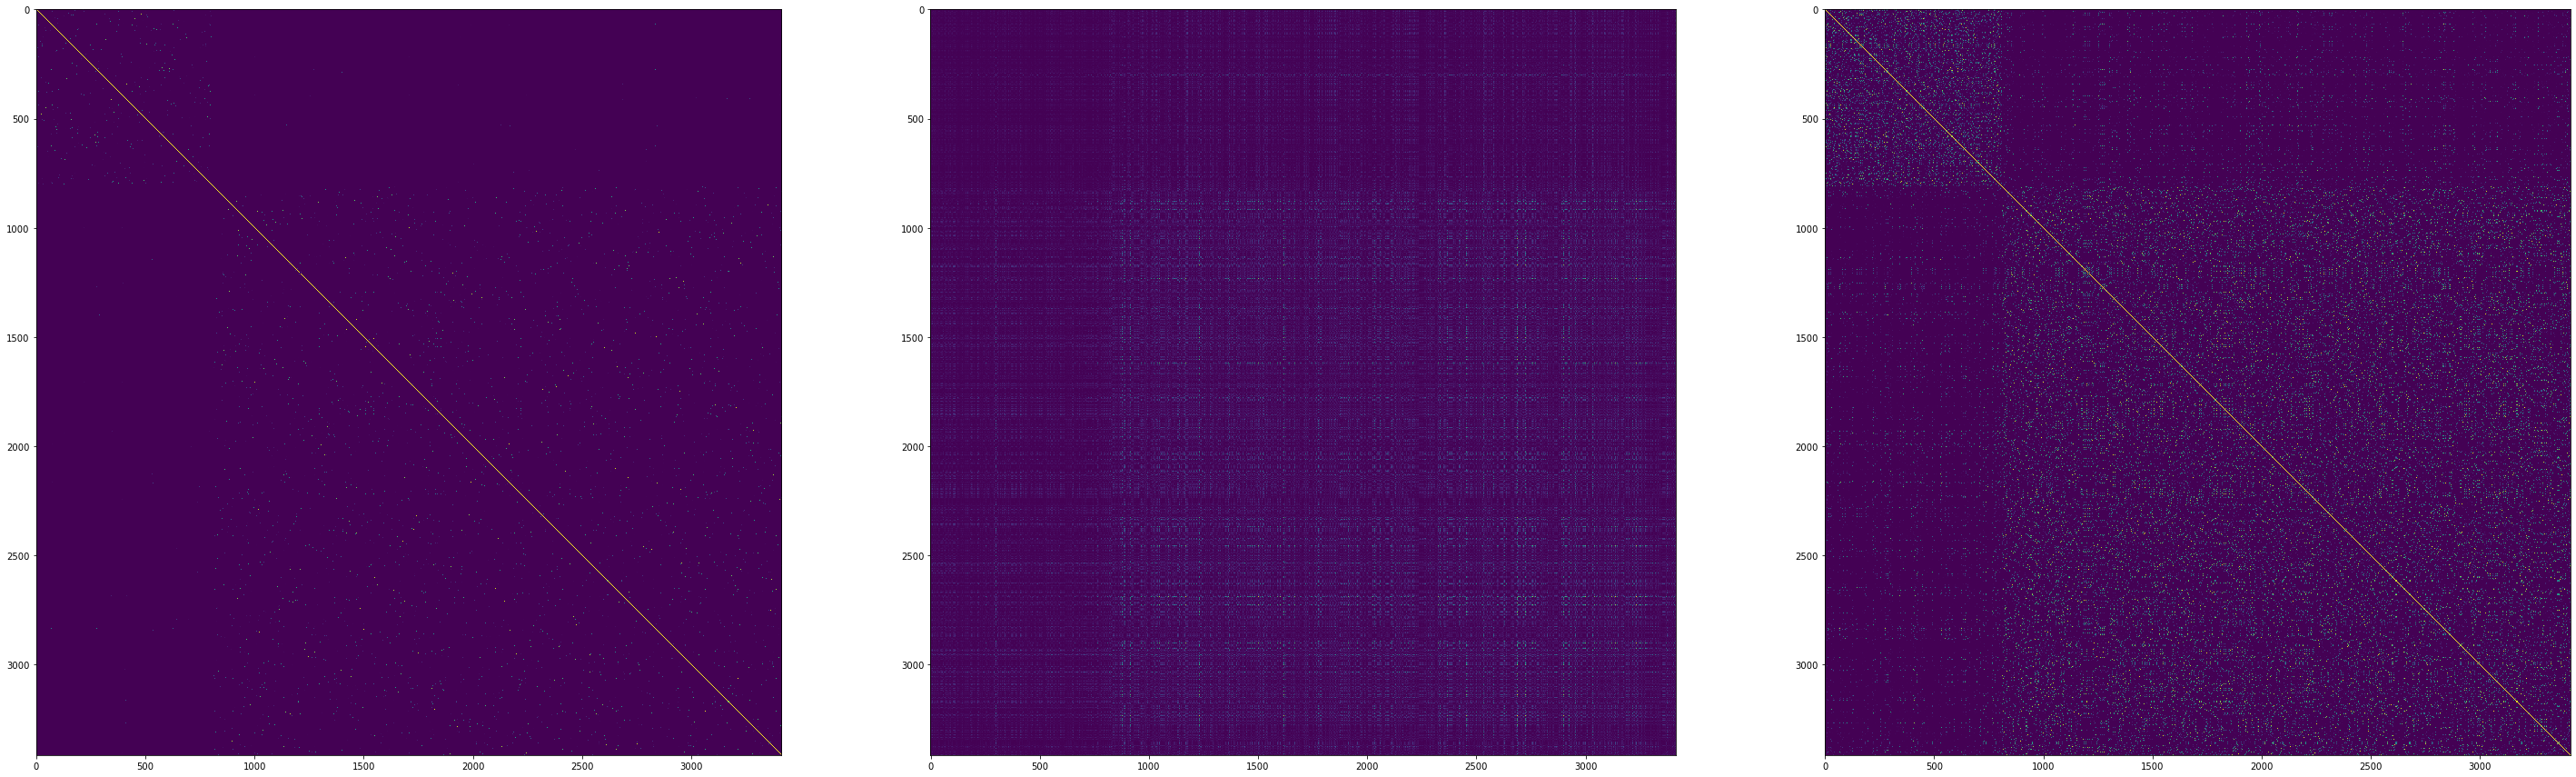

In [143]:
fig, ax = plt.subplots(1,3, sharex=True, figsize=(50,100))
ax[0].imshow(lis[:,:,0])
ax[1].imshow(lis[:,:,1])
ax[2].imshow(lis[:,:,2])
plt.show()

### Simulate infection dynamics
Pseudo code (try to modulize as much as possible)

while not finished{
    - Record disease state progression.
    - Stop simmulation if the outbreak is finished.
    
}


#### Control and Tracking variables
- track_states is a $d2s \times nCat$ matrix containing the distribution of the desease states for a given day.


In [170]:
# finished = False 
d2s = 2 # Number of time steps (days). #200.
nCat = 14 # Diseas state categories (0-13).
track_states = np.zeros((d2s,nCat)) 
op = 1 # ?
thosp = 0 # ?

In [173]:
def isFinished(track_states_i):
    return ( np.sum() ) # sum concatenated subaarray
    
def isFinished(track_states_i,N):
    return  (np.sum()) # Sum 0 and 6

In [176]:
N
pop_9.shape[0]


18700

In [165]:
    if i==d2s
        finished=1;
    end
    if ((sum(track_states(i,2:6))+sum(track_states(i,8:14)))==0 & i>10)
        finished=1;
    end

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [174]:
for i in range(d2s):
    print(i)
    track_states[0,:] = np.histogram(pop_9[:,1], bins=np.arange(nCat+1))[0] # Record states (disease progession)
    
    
    
    # finshed = True 
    #if finshed : break
    if isFinished(track_states) and 10<i : break
    #if isFinished(track_states) and 10<i : break

0
1
